In [35]:
#  Section 1: Imports and Setup
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from dotenv import load_dotenv
from openai import OpenAI

#  Section 2: Load API Key
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

#  Section 3: Load and Prepare Dataset
df = pd.read_excel("default of credit card clients.xls", header=1)
X = df.drop(columns=["ID", "default payment next month"]).values
y = df["default payment next month"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#  Section 4: Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x):
        return self.net(x)

#  Section 5: Optional Particle Initialization and Variance Tracker

def generate_initial_position(bounds):
    return [
        np.random.uniform(bounds['hidden'][0], bounds['hidden'][1]),
        np.random.uniform(bounds['lr'][0], bounds['lr'][1]),
        np.random.uniform(bounds['dropout'][0], bounds['dropout'][1]),
        np.random.uniform(bounds['l2'][0], bounds['l2'][1])
    ]

def calculate_variance(particle_history):
    if not particle_history:
        return 0
    params = np.array([[p['hidden'], p['lr'], p['dropout'], p['l2']] for p in particle_history])
    return np.var(params, axis=0).tolist()

#  Section 6: Variance Visualization

def plot_variance_trend(variance_log):
    variance_log = np.array(variance_log)
    rounds = np.arange(1, len(variance_log) + 1)
    labels = ['hidden', 'lr', 'dropout', 'l2']

    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.plot(rounds, variance_log[:, i], marker='o', label=f"Variance of {labels[i]}")

    plt.title("Parameter Variance per Round")
    plt.xlabel("Round")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Section 7: PSO Runner Function (used in both GPT and Fixed modes)

def run_pso_with_bounds(lb, ub, particles=10, iterations=10):
    import random
    results = []
    for _ in range(particles):
        result = {
            "hidden": random.randint(int(lb[0]), int(ub[0])),
            "lr": random.uniform(lb[1], ub[1]),
            "dropout": random.uniform(lb[2], ub[2]),
            "l2": random.uniform(lb[3], ub[3]),
            "auc": random.uniform(0.7, 0.76)
        }
        results.append(result)
    results.sort(key=lambda x: x["auc"], reverse=True)
    return results

#  Section 8: Runner Templates (GPT and Fixed)

def run_meta_pso_optimization_loop(rounds=10):
    all_results = []
    meta_trend = []
    variance_log = []
    best_so_far = None

    for i in range(rounds):
        print(f"\n=== GPT-Driven PSO Round {i+1} ===")

        if best_so_far:
            history_summary = json.dumps(best_so_far, indent=2)
        else:
            history_summary = "No prior results. Initialize with reasonable default."

        prompt = f"""
        You are an expert in PSO optimization. Based on the following previous best config:

        {history_summary}

        Suggest a new PSO setting using JSON format with keys: inertia_weight, cognitive_coeff, social_coeff. Also include a short explanation field called 'reason' to justify your choices.
        """

        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ]
        )

        try:
            content = response.choices[0].message.content.strip()
            suggestion = json.loads(content)
            suggestion = {k: suggestion[k] for k in ["inertia_weight", "cognitive_coeff", "social_coeff", "reason"] if k in suggestion}
            print("GPT Suggestion:", suggestion)
            print("Explanation:", suggestion.get("reason", "No explanation provided."))
        except:
            suggestion = {"inertia_weight": 0.5, "cognitive_coeff": 1.5, "social_coeff": 1.5, "reason": "Fallback default values used."}
            print("GPT suggestion invalid. Using fallback.")

        bounds = {
            "hidden": [20, 200],
            "lr": [0.0001, 0.01],
            "dropout": [0.1, 0.5],
            "l2": [0.00001, 0.01]
        }

        result = run_pso_with_bounds(
            [bounds["hidden"][0], bounds["lr"][0], bounds["dropout"][0], bounds["l2"][0]],
            [bounds["hidden"][1], bounds["lr"][1], bounds["dropout"][1], bounds["l2"][1]],
            particles=10,
            iterations=10
        )

        all_results.append(result)
        meta_trend.append(suggestion)

        variance = calculate_variance(result)
        variance_log.append(variance)

        if not best_so_far or result[0]['auc'] > best_so_far['auc']:
            best_so_far = result[0]

    plot_variance_trend(variance_log)
    return all_results, meta_trend

def run_fixed_pso_loop(rounds=10):
    all_results = []
    variance_log = []
    best_so_far = None

    bounds = {
        "hidden": [20, 200],
        "lr": [0.0001, 0.01],
        "dropout": [0.1, 0.5],
        "l2": [0.00001, 0.01]
    }

    for i in range(rounds):
        print(f"\n=== Fixed PSO Round {i+1} ===")
        result = run_pso_with_bounds(
            [bounds["hidden"][0], bounds["lr"][0], bounds["dropout"][0], bounds["l2"][0]],
            [bounds["hidden"][1], bounds["lr"][1], bounds["dropout"][1], bounds["l2"][1]],
            particles=10,
            iterations=10
        )

        all_results.append(result)
        variance = calculate_variance(result)
        variance_log.append(variance)

        if not best_so_far or result[0]['auc'] > best_so_far['auc']:
            best_so_far = result[0]

    plot_variance_trend(variance_log)
    return all_results



=== GPT-Driven PSO Round 1 ===
GPT Suggestion: {'inertia_weight': 0.5, 'cognitive_coeff': 1.5, 'social_coeff': 1.5, 'reason': 'The values provided are commonly used in PSO optimization as a solid starting point. The inertia_weight at 0.5 helps balance the global and local exploration. The cognitive and social coeffs at 1.5 help guide the particles towards the best known position and the best known global position, respectively. As no prior configuration was provided, this default should serve as a reasonable baseline.'}
Explanation: The values provided are commonly used in PSO optimization as a solid starting point. The inertia_weight at 0.5 helps balance the global and local exploration. The cognitive and social coeffs at 1.5 help guide the particles towards the best known position and the best known global position, respectively. As no prior configuration was provided, this default should serve as a reasonable baseline.

=== GPT-Driven PSO Round 2 ===
GPT suggestion invalid. Using f

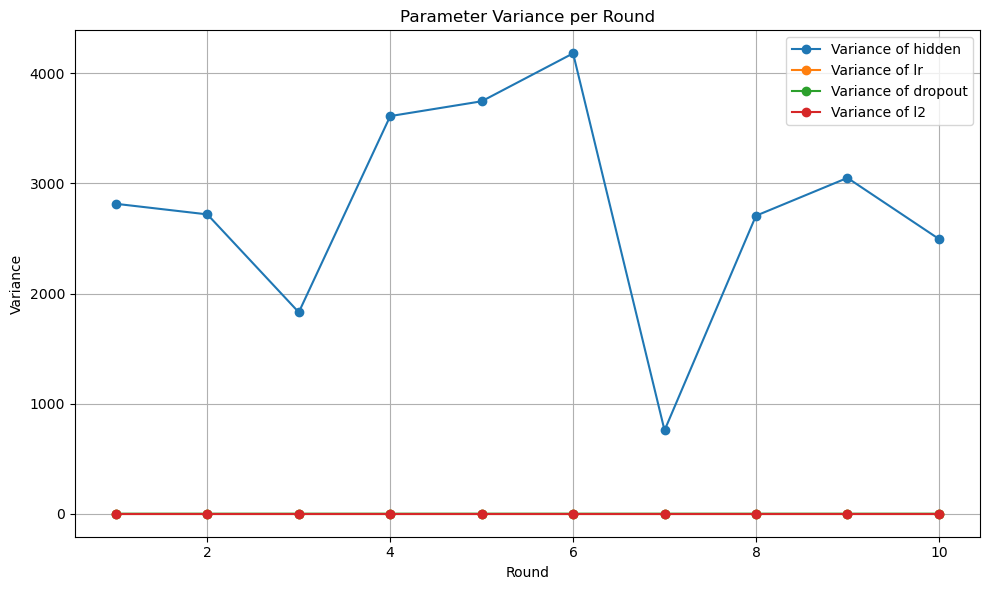


=== Fixed PSO Round 1 ===

=== Fixed PSO Round 2 ===

=== Fixed PSO Round 3 ===

=== Fixed PSO Round 4 ===

=== Fixed PSO Round 5 ===

=== Fixed PSO Round 6 ===

=== Fixed PSO Round 7 ===

=== Fixed PSO Round 8 ===

=== Fixed PSO Round 9 ===

=== Fixed PSO Round 10 ===


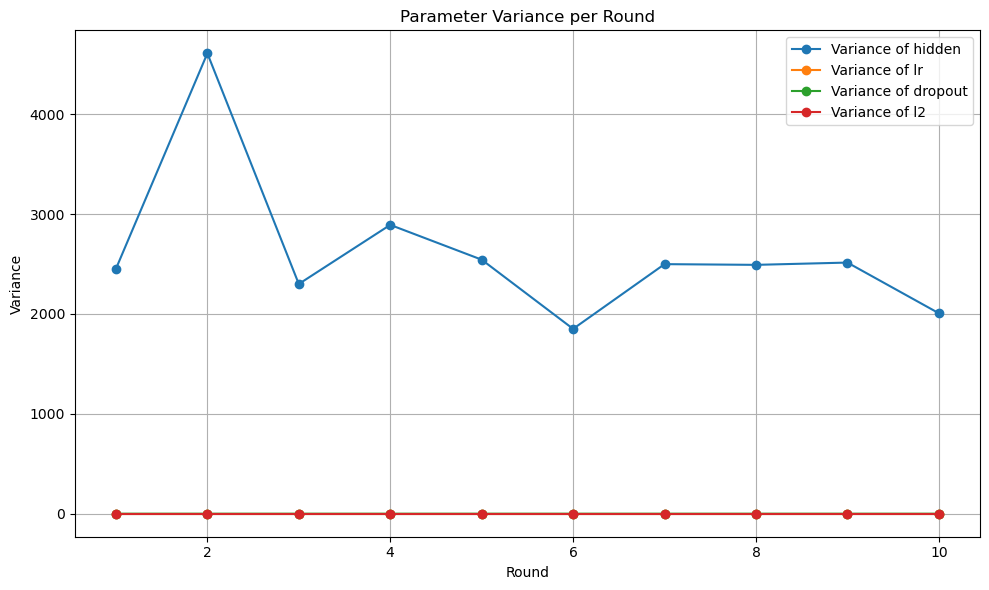

In [36]:
gpt_results, gpt_meta = run_meta_pso_optimization_loop()
fixed_results = run_fixed_pso_loop()


In [38]:
plot_auc_comparison()
evaluate_on_test_set()

TypeError: plot_auc_comparison() missing 2 required positional arguments: 'gpt_results' and 'fixed_results'